In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mne import read_epochs, compute_rank
from mne.decoding import CSP
from mne.preprocessing import ICA
from mne.time_frequency import tfr_multitaper
from mne.decoding import UnsupervisedSpatialFilter

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, ShuffleSplit

from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [2]:
epochs = read_epochs('ica_epo.fif')

Reading C:\Users\Alberto\Documents\BCI\data\dnn\ica_epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    7999.02 ms
        0 CTF compensation matrices available
Not setting metadata
65 matching events found
No baseline correction applied
0 projection items activated


Time Frequency Analysis

In [10]:
channels = ['FC5','FC3','C3','C5','CP3','CP5','P3']
conditions = ['left','right','rest']
tmin = -1.5
tmax = 2

In [47]:
freqs = np.arange(7,120)
freq_bounds = {
    '_': 0,
    'delta': 3,
    'theta': 7,
    'alpha': 13,
    'beta' : 35,
    'l-gamma': 70,
    'm-gamma': 90,
    'h-gamma': 120
}


In [11]:
tfr = tfr_multitaper(epochs[conditions].copy().filter(1,120,n_jobs=8).pick(channels), freqs=freqs, n_cycles=freqs, n_jobs=8, use_fft=True,
        return_itc=False, average=False, decim=2)
tfr.apply_baseline((-0.9,-0.1), mode='percent')
tfr.crop(tmin,tmax)

Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1016 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 2594 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 2688 out of 2688 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   7 | elapsed:   45.3s remaining:  1.9min
[Parallel(n_jobs=8)]: Done   4 out of   7 | elapsed:   46.5s remaining:   34.8s
[Parallel(n_jobs=8)]: Done   7 out of   7 | elapsed:   48.1s finished


Not setting metadata
Applying baseline correction (mode: percent)


<EpochsTFR | time : [-1.500000, 2.000000], freq : [7.000000, 119.000000], epochs : 42, channels : 7, ~454.5 MB>

In [12]:
df = tfr.to_data_frame(time_format=None, long_format=True)
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()), labels=list(freq_bounds)[1:])

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


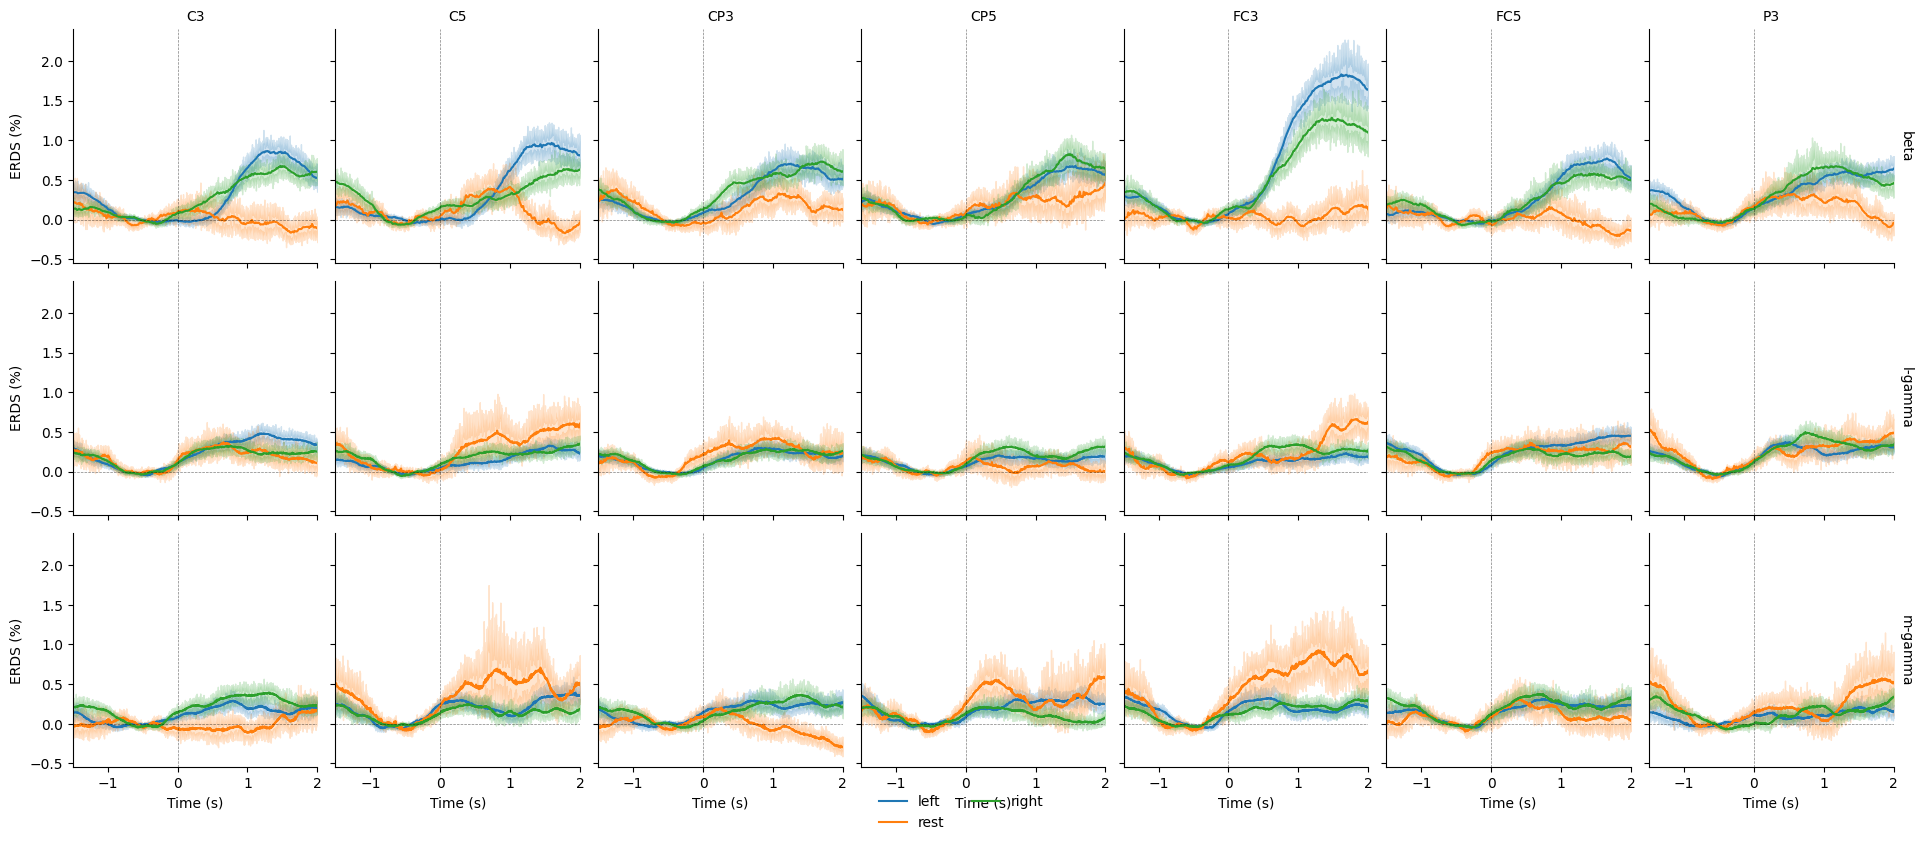

In [13]:
df = df[df.band.isin(['beta','l-gamma','m-gamma'])]
df['band'] = df['band'].cat.remove_unused_categories()
g = sns.FacetGrid(df, row='band', col='channel', margin_titles=True)
g.map(sns.lineplot, 'time', 'value', 'condition', n_boot=10)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
# g.set(ylim=(None, 1.5))
g.set(xlim=(tmin, tmax))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

Binary CSP + LDA classification

In [13]:
conditions = ['left','right']
subset = epochs[conditions].copy()
subset.drop_channels(subset.info['bads'])
subset = subset.pick(['eeg'])
compute_rank(subset)

Computing rank from data with rank=None
    Using tolerance 2.3e-08 (2.2e-16 eps * 45 dim * 2.3e+06  max singular value)
    Estimated rank (eeg): 45
    EEG: rank 45 computed from 45 data channels with 0 projectors


{'eeg': 45}

In [14]:
min_freq = 7.
max_freq = 120.
tmin = 0.1
tmax = 1.6
n_freqs = 10  # how many frequency bins to use
components = 5
classes = list(subset.event_id.keys())

In [15]:
csp = CSP(n_components=components, reg=None, log=True, norm_trace=False, rank='info')
clf = make_pipeline(csp, LinearDiscriminantAnalysis())
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=34)
le = LabelEncoder()

In [16]:
freqs = [2.,7.,18.,30.,40.,60.,70.,90.,100.,110.,120.]
freq_ranges = list(zip(freqs[:-1], freqs[1:]))
freq_labels = []
freq_scores = []

In [17]:
subset = subset.apply_baseline((-1.4,-0.1))
y = le.fit_transform(subset.events[:,2])

Applying baseline correction (mode: mean)


In [18]:
for freq, (fmin, fmax) in enumerate(freq_ranges):
    test = subset.copy().crop(tmin,tmax).filter(fmin, fmax, n_jobs=4) 
    test.drop_channels(test.info['bads'])
    
    if tmin > 3 and (conditions[1] == 'rest'):
        rest = subset['rest'].copy().crop(0, tmax-tmin).filter(fmin, fmax, n_jobs=4)
        rest.drop_channels(rest.info['bads'])
        X = np.concatenate([test[condtion[0]].get_data(), rest.get_data()])
    else:
        X = test.get_data()
    
    chance = np.mean(y == y[0])
    chance = max(chance, 1. - chance)
        
    freq_labels.append(str(int(fmax)))
    freq_scores.append(
        cross_val_score(
            estimator=clf, X=X, y=y, scoring='roc_auc', cv=cv, n_jobs=8))
    
    print(freq_labels)
    print('SCORE '+str(np.mean(freq_scores)))

Setting up band-pass filter from 2 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 8.00 Hz)
- Filter length: 1691 samples (1.651 sec)



C:\Users\Alberto\AppData\Local\Temp\ipykernel_13876\965692713.py:2: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(tmin,tmax).filter(fmin, fmax, n_jobs=4)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 1080 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 1122 out of 1125 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 1125 out of 1125 | elapsed:    2.1s finished


['7']
SCORE nan
Setting up band-pass filter from 7 - 18 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 18.00 Hz
- Upper transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 20.25 Hz)
- Filter length: 1691 samples (1.651 sec)



C:\Users\Alberto\AppData\Local\Temp\ipykernel_13876\965692713.py:2: RuntimeWarning: filter_length (1691) is longer than the signal (1537), distortion is likely. Reduce filter length or filter a longer signal.
  test = subset.copy().crop(tmin,tmax).filter(fmin, fmax, n_jobs=4)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 946 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 1122 out of 1125 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 1125 out of 1125 | elapsed:    2.0s finished


['7', '18']
SCORE nan
Setting up band-pass filter from 18 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 18.00
- Lower transition bandwidth: 4.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 751 samples (0.733 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 1080 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 1122 out of 1125 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 1125 out of 1125 | elapsed:    2.0s finished


['7', '18', '30']
SCORE nan
Setting up band-pass filter from 30 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 451 samples (0.440 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 950 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 1122 out of 1125 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 1125 out of 1125 | elapsed:    1.9s finished


['7', '18', '30', '40']
SCORE nan
Setting up band-pass filter from 40 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 339 samples (0.331 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 1072 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 1122 out of 1125 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 1125 out of 1125 | elapsed:    1.8s finished


['7', '18', '30', '40', '60']
SCORE nan
Setting up band-pass filter from 60 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 60.00
- Lower transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 52.50 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 227 samples (0.222 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 950 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 1122 out of 1125 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 1125 out of 1125 | elapsed:    1.8s finished


['7', '18', '30', '40', '60', '70']
SCORE nan
Setting up band-pass filter from 70 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 70.00
- Lower transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 61.25 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 101.25 Hz)
- Filter length: 195 samples (0.190 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 954 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 1122 out of 1125 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 1125 out of 1125 | elapsed:    2.1s finished


['7', '18', '30', '40', '60', '70', '90']
SCORE nan
Setting up band-pass filter from 90 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 90.00
- Lower transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 151 samples (0.147 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 1080 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 1122 out of 1125 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 1125 out of 1125 | elapsed:    2.0s finished


['7', '18', '30', '40', '60', '70', '90', '100']
SCORE nan
Setting up band-pass filter from 1e+02 - 1.1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 100.00
- Lower transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 87.50 Hz)
- Upper passband edge: 110.00 Hz
- Upper transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 123.75 Hz)
- Filter length: 137 samples (0.134 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 1076 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 1122 out of 1125 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 1125 out of 1125 | elapsed:    2.1s finished


['7', '18', '30', '40', '60', '70', '90', '100', '110']
SCORE nan
Setting up band-pass filter from 1.1e+02 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 110.00
- Lower transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 96.25 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 123 samples (0.120 sec)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 946 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 1122 out of 1125 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 1125 out of 1125 | elapsed:    4.7s finished


['7', '18', '30', '40', '60', '70', '90', '100', '110', '120']
SCORE nan


In [19]:
scores_df = pd.DataFrame(data=np.transpose(freq_scores), columns=[freq_labels])

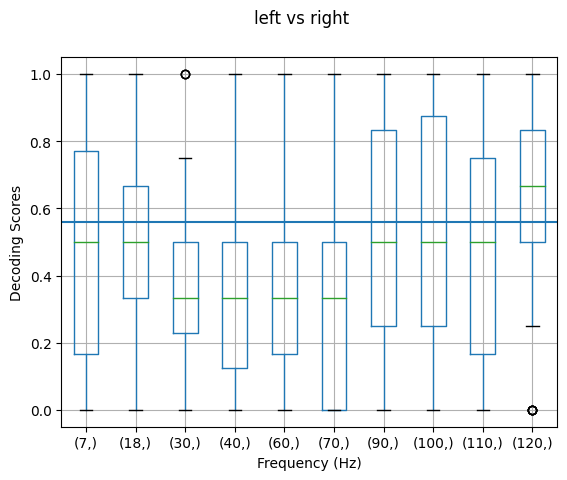

In [20]:
csp_fig, axes = plt.subplots(1)
scores_df.boxplot(ax=axes)
axes.axhline(chance)
axes.set_xlabel('Frequency (Hz)')
axes.set_ylabel('Decoding Scores')
csp_fig.suptitle(classes[0]+' vs '+classes[1])
plt.show()

In [21]:
score_median = []
scores_df = scores_df.dropna()
for col in scores_df.columns:
    score_median.append(np.median(scores_df[col]))

In [22]:
score_median

[0.5,
 0.5,
 0.33333333333333337,
 0.33333333333333337,
 0.33333333333333337,
 0.33333333333333337,
 0.5,
 0.5,
 0.5,
 0.6666666666666666]

In [44]:
del subset